In [35]:
import pandas as pd
import sqlalchemy as sa

engine = sa.create_engine(open(r"S:\Data Science\sandboxes\Jawad\patient_LOS_project\SQL_query\connection_engine.txt").read())

with engine.connect() as conn:
   initial_elect_df = pd.read_sql(open(r"S:\Data Science\sandboxes\Jawad\patient_LOS_project\SQL_query\elective_sql_queries\elective_main_Los.sql").read(), con=conn.connection)

<>:4: SyntaxWarning:

invalid escape sequence '\D'

<>:7: SyntaxWarning:

invalid escape sequence '\D'

<>:4: SyntaxWarning:

invalid escape sequence '\D'

<>:7: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_7360\543648984.py:4: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_7360\543648984.py:7: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_7360\543648984.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [36]:
df_elect = initial_elect_df.copy()

In [37]:
len(initial_elect_df)

4305

In [38]:
df_elect.isna().sum()

admission_datetime          0
weekend                     0
time_of_day                 0
month                       0
WardAdmission               0
Los                         0
PriorityType              771
IntendedManagement          0
AdmissionMethod             0
SourceOfAdmission           0
em_el_dc                    0
DischargeDestination        0
EthnicCategory            173
AgeOnAdmission              0
StartSexofPatientsCode      0
PrimaryDiagnosisICD         0
Description                 0
Chapter_Number              0
Chapter_Description         0
IMD_Decile                  0
dtype: int64

In [46]:
df_elect_unique = df_elect.drop_duplicates(subset=['admission_datetime', 'Los', 'AgeOnAdmission']).copy()

In [47]:
len(df_elect_unique)

1627

<Axes: xlabel='Los', ylabel='Count'>

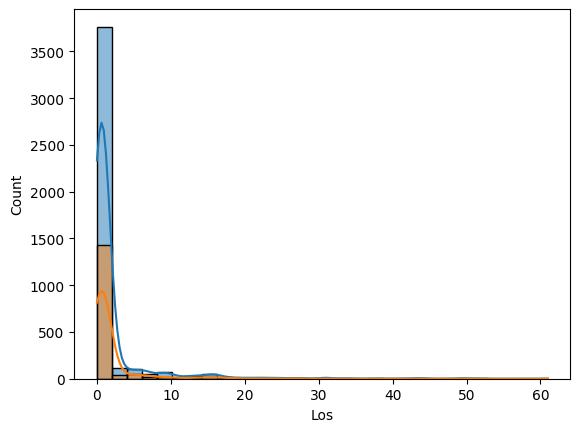

In [48]:
import seaborn as sns
sns.histplot(df_elect['Los'], bins=30, kde=True)
sns.histplot(df_elect_unique['Los'], bins=30, kde=True)


In [51]:
df_elect_unique['year_month'] = df_elect_unique['admission_datetime'].dt.strftime('%Y-%m')

In [54]:
import pandas as pd
import plotly.graph_objects as go

avg_los_month = df_elect_unique.groupby('year_month')['Los'].mean().reset_index()
avg_los_month1 = df_elect_unique.groupby('year_month')['Los'].median().reset_index()

# Create the plot
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=avg_los_month['year_month'],
        y=avg_los_month['Los'],
        mode='lines+markers',
        name='Average LOS mean',
        line=go.scatter.Line(shape='spline')
    )
)

fig.add_trace(
    go.Scatter(
        x=avg_los_month1['year_month'],
        y=avg_los_month1['Los'],
        mode='lines+markers',
        name='Average LOS median',
        line=go.scatter.Line(shape='spline')
    )
)

# Update layout
fig.update_layout(
    title='Average LOS Per Month (2021–2024) - ELECT',
    xaxis_title='Month',
    yaxis_title='Length of Stay (Days)',
    template='plotly_white',
    margin=dict(l=20, r=20, t=40, b=40),
    xaxis=dict(tickangle=50)
)

fig.show()


In [67]:
import plotly.graph_objects as go

label_map = {0: 'Weekday', 1: 'Weekend'}
monthly_avg_week_weekend = df_elect_unique.groupby(['year_month', 'weekend'])['Los'].count().reset_index()
monthly_avg_week_weekend['weekend_label'] = monthly_avg_week_weekend['weekend'].map(label_map)

methods = monthly_avg_week_weekend['weekend_label'].unique()

# Create a trace for each label
traces = [
    go.Scatter(
        x=monthly_avg_week_weekend[monthly_avg_week_weekend['weekend_label'] == method]['year_month'],
        y=monthly_avg_week_weekend[monthly_avg_week_weekend['weekend_label'] == method]['Los'],
        mode='lines+markers',
        name=method,
        line=go.scatter.Line(shape='spline')
    )
    for method in methods
]

# Assemble the figure
fig = go.Figure(data=traces)
fig.update_layout(
    title='Average number of Admission by Weekday vs Weekend Per Month',
    xaxis_title='Month',
    yaxis_title='Length of Stay (Days)',
    template='plotly_white',
    legend_title='Admission Type',
    margin=dict(l=40, r=20, t=40, b=40)
)

fig.show()


In [71]:
df_elect_unique = df_elect_unique.drop(columns=['admission_datetime' ,'em_el_dc', 'DischargeDestination', 'Description', 'Chapter_Description', 'WardAdmission', 'year_month'])

In [73]:
XGB_model_df = df_elect_unique.copy()

In [75]:
XGB_model_df['PriorityType'] = XGB_model_df['PriorityType'].fillna(XGB_model_df['PriorityType'].mode()[0])
XGB_model_df['EthnicCategory'] = XGB_model_df['EthnicCategory'].fillna(XGB_model_df['EthnicCategory'].mode()[0])

In [76]:
import optuna
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

#Feature List
num_cols = ['AgeOnAdmission']
low_card_cols = ['weekend','StartSexofPatientsCode','time_of_day', 'IntendedManagement', 'PriorityType']
high_card_cols = ['AdmissionMethod','SourceOfAdmission','EthnicCategory','Chapter_Number' ,'IMD_Decile','month', 'PrimaryDiagnosisICD']


#Data Split
target_col = 'Los'
X = XGB_model_df.drop(columns=[target_col])
y = XGB_model_df[target_col]

#Target encoding
for col in high_card_cols:
    X[col] = XGB_model_df.groupby(col)['Los'].transform('mean')


# Combine preprocessing steps
preprocessor = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), low_card_cols)],
                                 remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

C:\Users\jawad.iqbal\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [77]:
#Optuna Objective Function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }


    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(**params))
    ])

    regressor = TransformedTargetRegressor(
        regressor=pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    return mean_squared_error(y_test, y_pred)

#Run Optuna Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial params:", study.best_trial.params)

[I 2025-08-27 22:41:15,460] A new study created in memory with name: no-name-41db0174-359c-420a-871e-001baf4f2666
[I 2025-08-27 22:41:17,114] Trial 0 finished with value: 24.33123207092285 and parameters: {'n_estimators': 892, 'max_depth': 10, 'learning_rate': 0.08512659117638041, 'subsample': 0.6153155772313283, 'colsample_bytree': 0.6684748636429463, 'reg_alpha': 0.41815756811043026, 'reg_lambda': 0.8688849569417993}. Best is trial 0 with value: 24.33123207092285.
[I 2025-08-27 22:41:17,826] Trial 1 finished with value: 23.75708770751953 and parameters: {'n_estimators': 901, 'max_depth': 6, 'learning_rate': 0.06970000848550736, 'subsample': 0.7772005036583318, 'colsample_bytree': 0.6621919748525122, 'reg_alpha': 1.9273521351534035, 'reg_lambda': 0.08422544787190188}. Best is trial 1 with value: 23.75708770751953.
[I 2025-08-27 22:41:18,851] Trial 2 finished with value: 24.4100399017334 and parameters: {'n_estimators': 898, 'max_depth': 10, 'learning_rate': 0.015831773976634322, 'subs

Best trial params: {'n_estimators': 588, 'max_depth': 7, 'learning_rate': 0.17496243718467508, 'subsample': 0.8430995997793533, 'colsample_bytree': 0.6564061204614158, 'reg_alpha': 1.298352708746824, 'reg_lambda': 0.07072722288052663}


In [78]:
#Train Final Model
best_params = study.best_trial.params
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(**best_params))
])

regressor = TransformedTargetRegressor(
    regressor=final_model,
    func=np.log1p,
    inverse_func=np.expm1
)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"Final Test MAE: {mae:.3f}, RMSE: {rmse:.3f}, R² Score: {r2:.4f}")

Final Test MAE: 1.634, RMSE: 27.095, R² Score: 0.0626


In [80]:
import pandas as pd
import sqlalchemy as sa

engine = sa.create_engine(open(r"S:\Data Science\sandboxes\Jawad\patient_LOS_project\SQL_query\connection_engine.txt").read())

with engine.connect() as conn:
   test_df = pd.read_sql(open(r"S:\Data Science\sandboxes\Jawad\patient_LOS_project\SQL_query\elective_sql_queries\elect_test_sql.sql").read(), con=conn.connection)

C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_7360\1059874642.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [91]:
len(test_df)

459

In [94]:
test_elect = test_df.copy()

In [95]:
test_elect = test_elect.drop_duplicates()

In [96]:
test_elect = test_elect.dropna()

In [97]:
test_elect = test_elect.drop(columns=['admission_datetime'])

In [98]:
len(test_elect)

162

In [103]:
test_elect['time_of_day'].value_counts()

time_of_day
2    99
1    63
Name: count, dtype: int64

In [101]:
elect_predictions = regressor.predict(test_elect)

In [104]:
t_r2 = r2_score(test_elect['Los'], elect_predictions)
t_mae = mean_absolute_error(test_elect['Los'], elect_predictions)
t_rmse = np.sqrt(mean_squared_error(test_elect['Los'], elect_predictions))

print(f"Unseen Test MAE: {t_mae:.3f}, RMSE: {t_rmse:.3f}, R² Score: {t_r2:.4f}")

Unseen Test MAE: 2.248, RMSE: 4.304, R² Score: -0.7770


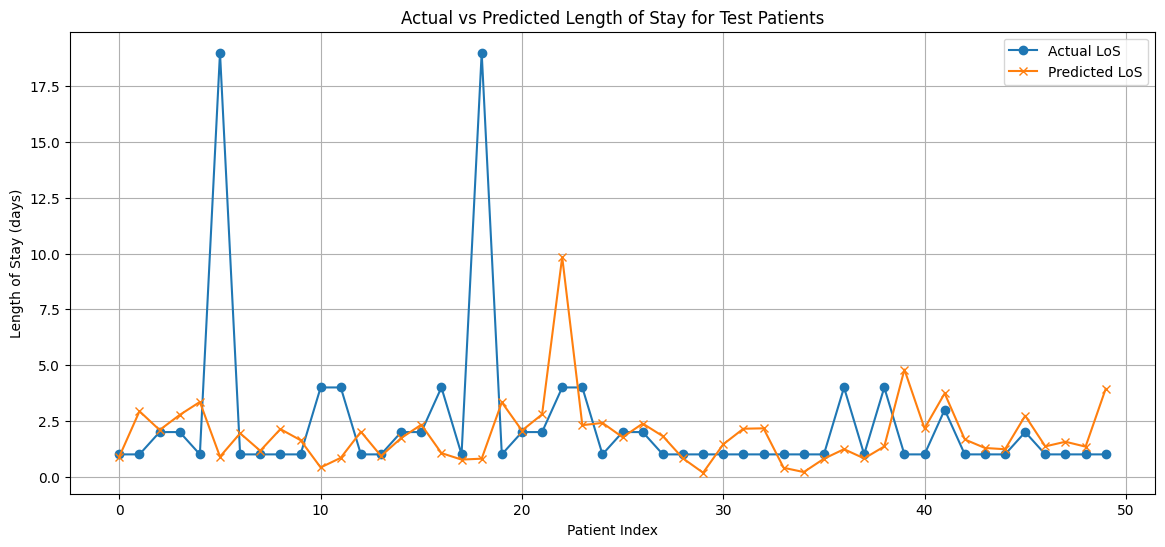

In [105]:

import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays for indexing
y_test_array = np.array(test_elect['Los'][:50])
y_pred_array = np.array(elect_predictions[:50])

# Create an index for each patient
indices = np.arange(len(y_test_array))

# Plot actual vs predicted as line plot
plt.figure(figsize=(14, 6))
plt.plot(indices, y_test_array, label='Actual LoS', marker='o')
plt.plot(indices, y_pred_array, label='Predicted LoS', marker='x')
plt.xlabel('Patient Index')
plt.ylabel('Length of Stay (days)')
plt.title('Actual vs Predicted Length of Stay for Test Patients')
plt.legend()
plt.grid(True)
